# Evaluation and comparison of results for Stochastic Deconvolution

In [219]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px 
import matplotlib.pyplot as plt
import cv2
from skimage.metrics import structural_similarity as ssim

In [220]:
time_headers = ['regularizer', 'time(s)']
time_df = pd.read_csv('out_files/time.csv', encoding='utf-8')
time_df

,regularizer,time(s)
0,tv,27.173
1,gamma,237.011
2,combination,241.905
3,sparse,139.963
4,data,54.821
5,discontinuous,95.703
6,opencv,11.148
7,original,9.649


In [221]:
data_headers = ['regularizer','iteration', 'acceptance', 'ed']

tv_df = pd.read_csv('out_files/tv.csv', encoding='utf-8')
gamma_df = pd.read_csv('out_files/gamma.csv', encoding='utf-8')
combination_df = pd.read_csv('out_files/combination.csv', encoding='utf-8')
sparse_df = pd.read_csv('out_files/sparse.csv', encoding='utf-8')
data_df = pd.read_csv('out_files/data.csv', encoding='utf-8')
discontinuous_df = pd.read_csv('out_files/discontinuous.csv', encoding='utf-8')

discontinuous_df.head()

,iteration,acceptance,ed
0,iteration 1 of 100,acceptance rate: 0.627897,ed: 0.025
1,iteration 2 of 100,acceptance rate: 0.373432,ed: 0.025
2,iteration 3 of 100,acceptance rate: 0.479864,ed: 0.0125
3,iteration 4 of 100,acceptance rate: 0.38072,ed: 0.0125
4,iteration 5 of 100,acceptance rate: 0.522547,ed: 0.00625


In [222]:
tv_df['regularizer'] = 'tv'
gamma_df['regularizer'] = 'gamma'
combination_df['regularizer'] = 'combination'
sparse_df['regularizer'] = 'sparse'
data_df['regularizer'] = 'data'
discontinuous_df['regularizer'] = 'discontinuous'

df = pd.concat([tv_df, gamma_df, combination_df, sparse_df, data_df, discontinuous_df], ignore_index=True)
df.head()

,iteration,acceptance,ed,regularizer
0,iteration 1 of 100,acceptance rate: 0.687215,ed: 0.025,tv
1,iteration 2 of 100,acceptance rate: 0.437559,ed: 0.025,tv
2,iteration 3 of 100,acceptance rate: 0.286948,ed: 0.025,tv
3,iteration 4 of 100,acceptance rate: 0.438144,ed: 0.0125,tv
4,iteration 5 of 100,acceptance rate: 0.343552,ed: 0.0125,tv


In [223]:
def clean_data(df):
    df['iteration'] = df['iteration'].astype(str)
    df['iteration'] = df['iteration'].str.split(' ').str[1]  
    df['iteration'] = df['iteration'].astype(int)

    df['acceptance'] = df['acceptance'].astype(str)
    df['acceptance'] = df['acceptance'].str.split(' ').str[3]  
    df['acceptance'] = df['acceptance'].astype(float)

    df['ed'] = df['ed'].astype(str)
    df['ed'] = df['ed'].str.split(' ').str[2]  
    df['ed'] = df['ed'].astype(float)


    return df

In [224]:
df = clean_data(df)
df

,iteration,acceptance,ed,regularizer
0,1,0.687215,0.025000,tv
1,2,0.437559,0.025000,tv
2,3,0.286948,0.025000,tv
3,4,0.438144,0.012500,tv
4,5,0.343552,0.012500,tv
...,...,...,...,...
595,96,0.488672,0.000098,discontinuous
596,97,0.486782,0.000098,discontinuous
597,98,0.484325,0.000098,discontinuous
598,99,0.481097,0.000098,discontinuous


## Evaluation metrics

In [225]:
original = cv2.imread('imgs/dandelion.jpg')
blurred = cv2.imread('imgs/blurred.png')
tv = cv2.imread('imgs/results/tv_intrinsic.png')
gamma = cv2.imread('imgs/results/gamma_intrinsic.png')
combination= cv2.imread('imgs/results/combination_intrinsic.png')
sparse = cv2.imread('imgs/results/sparse_intrinsic.png')
data = cv2.imread('imgs/results/data_intrinsic.png')
discontinuous = cv2.imread('imgs/results/discontinuous_intrinsic.png')

bw = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
opencv = cv2.imread('imgs/results/opencv_intrinsic.png', cv2.COLOR_BGR2GRAY)
original_implementation = cv2.imread('imgs/results/original_intrinsic.png', cv2.COLOR_BGR2GRAY)

list_images = [tv, gamma, combination, sparse, data, discontinuous, blurred]
list_names_images = ['tv', 'gamma', 'combination', 'sparse', 'data', 'discontinuous', 'blurred']

In [226]:
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:  # no difference between images
        return float('inf')
    max_pixel = 255.0
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr_value

def calculate_ssim(img1, img2):
    return ssim(img1, img2, data_range=img2.max() - img2.min(), channel_axis=-1)


In [227]:
df_evaluations = pd.DataFrame()

for i, img in enumerate(list_images):
    if img.shape != original.shape:
        raise ValueError("Images must have the same dimensions")
    
    # compute PSNR and SSIM
    psnr_value = calculate_psnr(original, img)
    ssim_value = calculate_ssim(original, img)

    df_evaluations = pd.concat([
        df_evaluations, 
        pd.DataFrame({'regularizer': [list_names_images[i]], 'PSNR': [psnr_value], 'SSIM': [ssim_value]})
    ], ignore_index=True)

bw_psnr_value = calculate_psnr(bw, opencv)
bw_ssim_value = calculate_ssim(bw, opencv)

df_evaluations = pd.concat([
        df_evaluations, 
        pd.DataFrame({'regularizer': ['opencv'], 'PSNR': [bw_psnr_value], 'SSIM': [bw_ssim_value]})
    ], ignore_index=True)


bw_psnr_value = calculate_psnr(bw, original_implementation)
bw_ssim_value = calculate_ssim(bw, original_implementation)

df_evaluations = pd.concat([
        df_evaluations, 
        pd.DataFrame({'regularizer': ['original'], 'PSNR': [bw_psnr_value], 'SSIM': [bw_ssim_value]})
    ], ignore_index=True)


df_evaluations


,regularizer,PSNR,SSIM
0,tv,32.807964,0.911336
1,gamma,31.450924,0.845198
2,combination,31.885773,0.871706
3,sparse,30.811755,0.793331
4,data,32.400302,0.897197
5,discontinuous,31.745519,0.869431
6,blurred,29.822259,0.623123
7,opencv,29.507723,0.901138
8,original,29.333178,0.899737


## Graphs

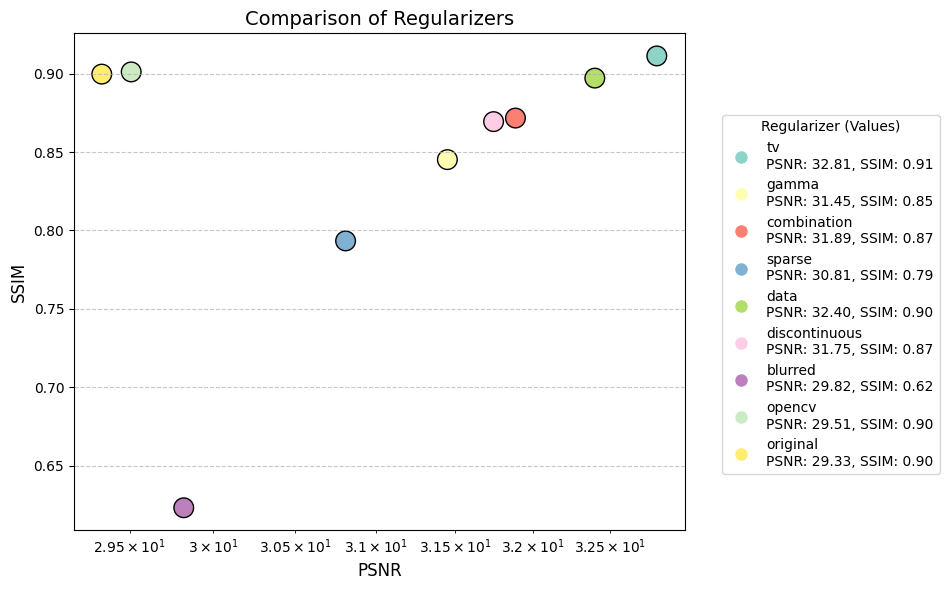

In [244]:
plt.figure(figsize=(8, 6))
sc = plt.scatter(df_evaluations['PSNR'], df_evaluations['SSIM'], s=200, c=np.arange(len(df_evaluations)), cmap='Set3', edgecolor='k')

# Add legend for regularizers with values, outside the plot
handles = [plt.Line2D([0], [0], marker='o', color='w', label=f"{row['regularizer']}\nPSNR: {row['PSNR']:.2f}, SSIM: {row['SSIM']:.2f}",
                      markersize=10, markerfacecolor=sc.cmap(sc.norm(i)))
           for i, row in df_evaluations.iterrows()]
plt.legend(handles=handles, title="Regularizer (Values)", bbox_to_anchor=(1.05, 0.85), loc='upper left', fontsize=10)

plt.xscale('log')
plt.xlabel('PSNR', fontsize=12)
plt.ylabel('SSIM', fontsize=12)
plt.title('Comparison of Regularizers', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout(rect=[0, 0, 1.2, 1])
plt.show()


In [229]:
df_evaluations['Quality'] = 0.5 * df_evaluations['PSNR'] + 0.5 * (df_evaluations['SSIM'] * 100)

df_merged = pd.merge(df_evaluations, time_df, on='regularizer', how='inner')
df_merged['time(s)'] = pd.to_numeric(df_merged['time(s)'], errors='coerce')

# Sort by Quality or Time in descending order (optional)
df_merged = df_merged.sort_values(by='time(s)', ascending=True)
df_merged

,regularizer,PSNR,SSIM,Quality,time(s)
7,original,29.333178,0.899737,59.653434,9.649
6,opencv,29.507723,0.901138,59.810748,11.148
0,tv,32.807964,0.911336,61.970804,27.173
4,data,32.400302,0.897197,61.059984,54.821
5,discontinuous,31.745519,0.869431,59.344292,95.703
3,sparse,30.811755,0.793331,55.072418,139.963
1,gamma,31.450924,0.845198,57.985367,237.011
2,combination,31.885773,0.871706,59.528171,241.905


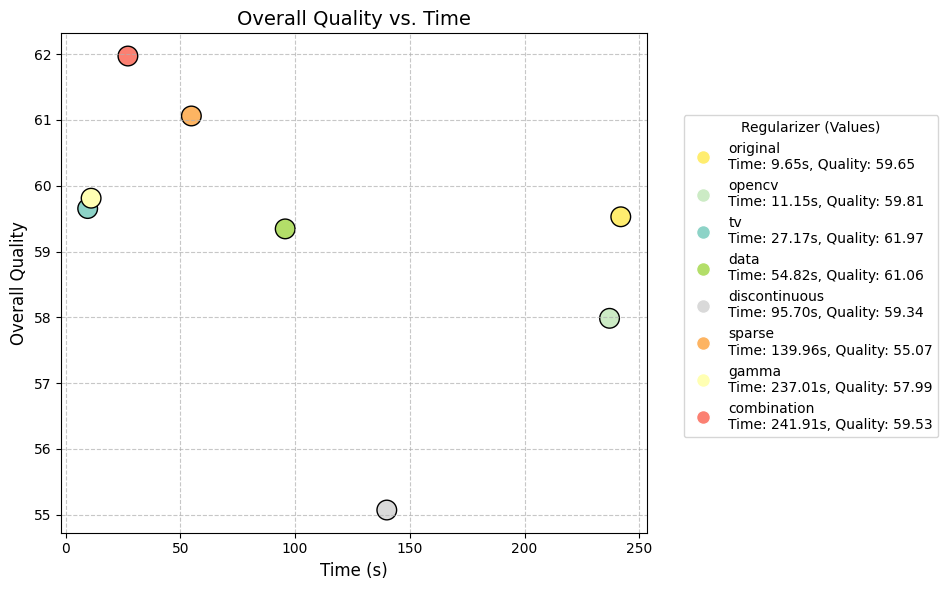

In [245]:
plt.figure(figsize=(8, 6))
sc = plt.scatter(df_merged['time(s)'], df_merged['Quality'], s=200, c=np.arange(len(df_merged)), cmap='Set3', edgecolor='k')

handles = [plt.Line2D([0], [0], marker='o', color='w', label=f"{row['regularizer']}\nTime: {row['time(s)']:.2f}s, Quality: {row['Quality']:.2f}",
                      markersize=10, markerfacecolor=sc.cmap(sc.norm(i)))
           for i, row in df_merged.iterrows()]
plt.legend(handles=handles, title="Regularizer (Values)", bbox_to_anchor=(1.05, 0.85), loc='upper left', fontsize=10)

plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Overall Quality', fontsize=12)
plt.title('Overall Quality vs. Time', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout(rect=[0, 0, 1.2, 1])
plt.show()

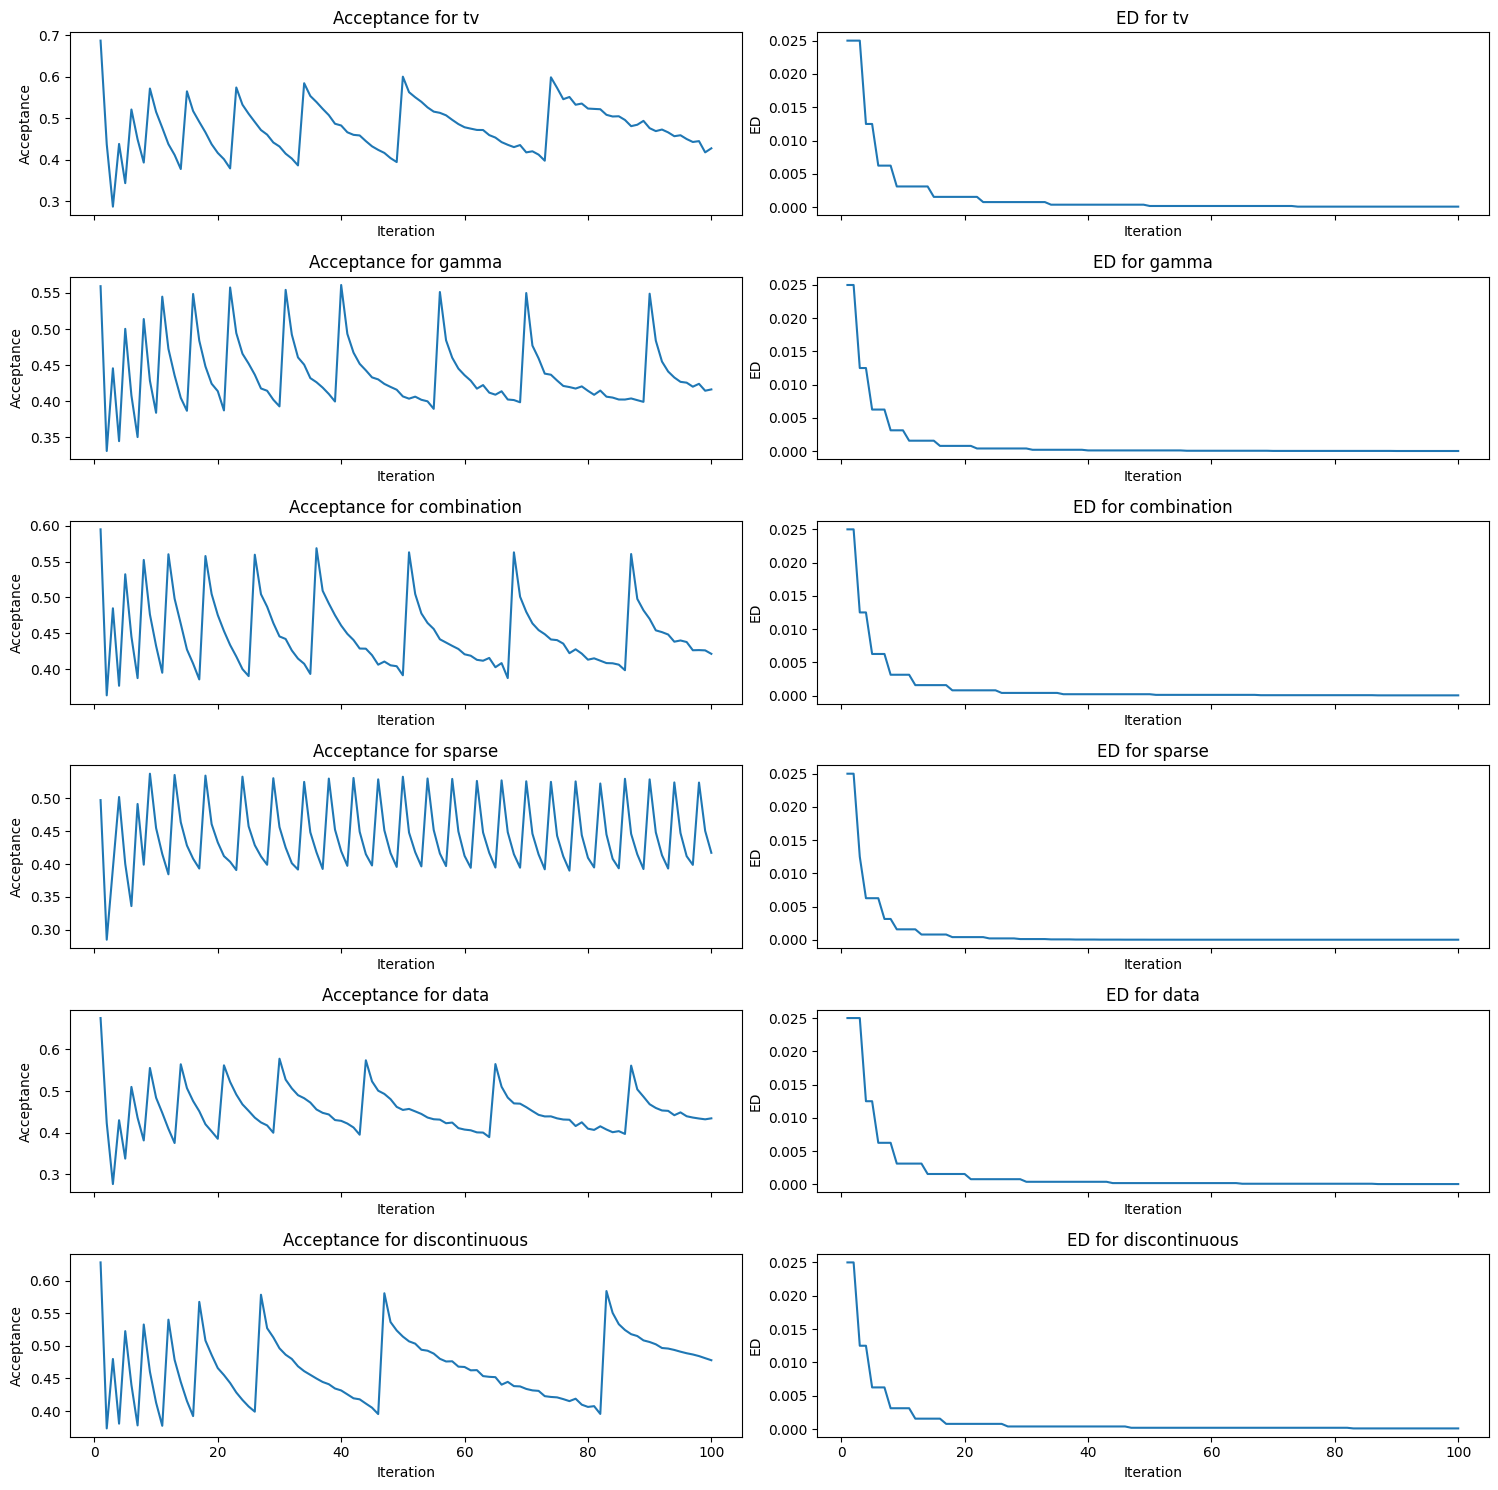

In [231]:
fig, axes = plt.subplots(len(df['regularizer'].unique()), 2, figsize=(15, 15), sharex=True)

regularizers = df['regularizer'].unique()
for i, reg in enumerate(regularizers):
    reg_df = df[df['regularizer'] == reg]
    axes[i, 0].plot(reg_df['iteration'], reg_df['acceptance'])
    axes[i, 0].set_title(f"Acceptance for {reg}")
    axes[i, 0].set_ylabel("Acceptance")
    axes[i, 0].set_xlabel("Iteration")
    
    axes[i, 1].plot(reg_df['iteration'], reg_df['ed'])
    axes[i, 1].set_title(f"ED for {reg}")
    axes[i, 1].set_ylabel("ED")
    axes[i, 1].set_xlabel("Iteration")

plt.tight_layout()
plt.show()


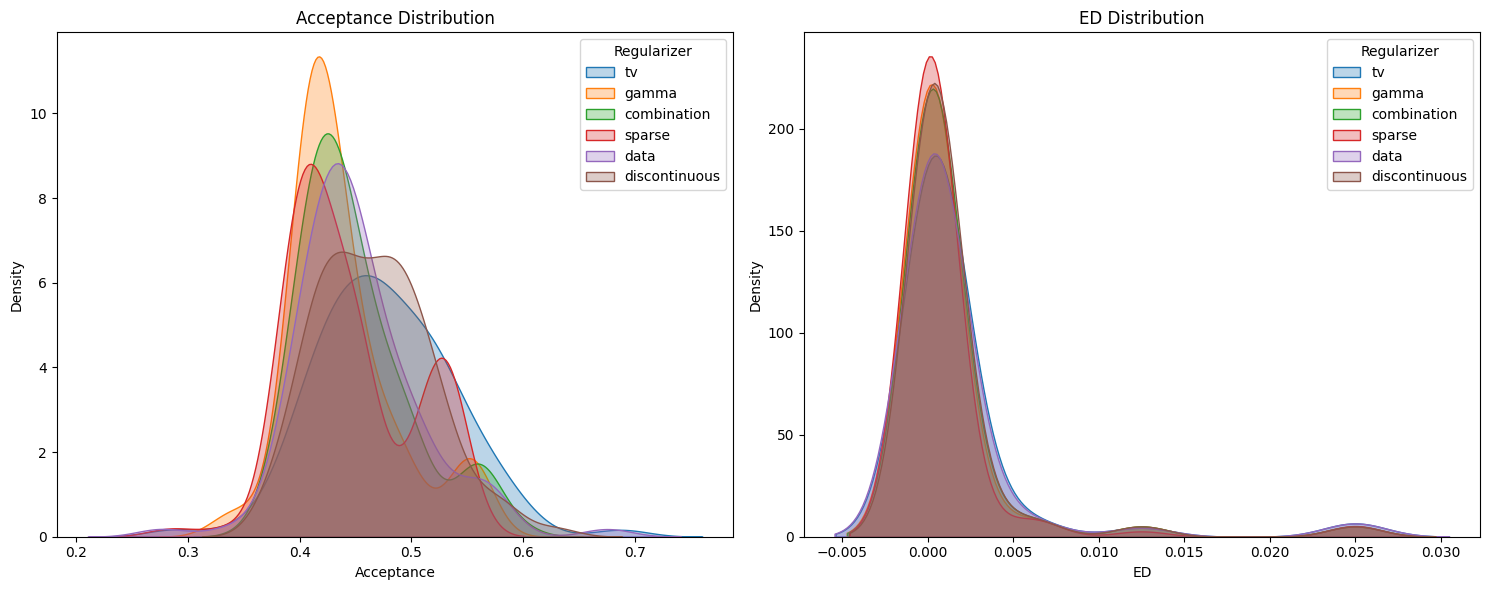

In [232]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# KDE for Acceptance
for reg in df['regularizer'].unique():
    reg_df = df[df['regularizer'] == reg]
    sns.kdeplot(reg_df['acceptance'], label=reg, ax=axes[0], fill=True, alpha=0.3)
axes[0].set_title("Acceptance Distribution")
axes[0].set_xlabel("Acceptance")
axes[0].set_ylabel("Density")
axes[0].legend(title="Regularizer")

# KDE for ED
for reg in df['regularizer'].unique():
    reg_df = df[df['regularizer'] == reg]
    sns.kdeplot(reg_df['ed'], label=reg, ax=axes[1], fill=True, alpha=0.3)
axes[1].set_title("ED Distribution")
axes[1].set_xlabel("ED")
axes[1].set_ylabel("Density")
axes[1].legend(title="Regularizer")

plt.tight_layout()
plt.show()
